In [6]:

import pandas as pd
from smallworld_api import SmallWorld

In [53]:
class LibrarySampler(object):
    
    def __init__(self):
        self.sw = SmallWorld()
    
    def sample(self, smiles_list):
        results : pd.DataFrame = sw.search(smiles_list[:10], dist=5, db="ChemSpace-BB-Stock-Mar2022")
        return results["smiles"]
        

In [54]:
smp = LibrarySampler()

In [55]:
import os
import pandas as pd
from rdkit import Chem
import csv

DATA = os.path.abspath("../data")
OUTPUT_PATH = os.path.join(DATA, "generated", "zairachem")
INPUT_PATH = os.path.join(DATA, "generated")

def read_smiles(file_name):
    with open(file_name, "r") as f:
        reader = csv.reader(f)
        smiles = []
        for r in reader:
            smiles += [r[0]]
    return smiles

smiles = read_smiles(os.path.join(INPUT_PATH, "known_hits.csv"))

In [56]:
res = smp.sample(smiles)

/home/mduranfrigola/miniconda3/envs/zairachem/lib/python3.7/site-packages/smallworld_api/__init__.py:66: UserWarning: ChemSpace-BB-Stock-Mar2022 is not a valid choice (['WuXi-20Q4.smi.anon', 'REAL_Space_21Q3_All_2B_public.smi.anon', 'all-zinc.smi.anon', 'wait-ok.smi.anon', 'MculeUltimate-20Q2.smi.anon', 'instock.smi.anon', 'BBall.smi.anon', 'BBnow.smi.anon', 'interesting.smi.anon']).Check updated with `.retrieve_scorefun_options()`
  'Check updated with `.retrieve_scorefun_options()`')


HTTPError: 502 Server Error: Proxy Error for url: https://sw.docking.org/search/submit?smi=O%3DC%28C1CCN%28C%29CC1%29NC2%3DCC%3DCC%28C3%3DCC%3DCC%3DC3%29%3DC2&db=ChemSpace-BB-Stock-Mar2022&dist=5&tdn=6&rdn=6&rup=2&ldn=2&lup=2&maj=6&min=6&sub=6

In [44]:
from rdkit.Chem import Draw
from rdkit import Chem

[18:49:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 24
[18:49:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 23
[18:49:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 23
[18:49:32] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[18:49:32] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[18:49:32] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 19
/home/mduranfrigola/miniconda3/envs/zairachem/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:254: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


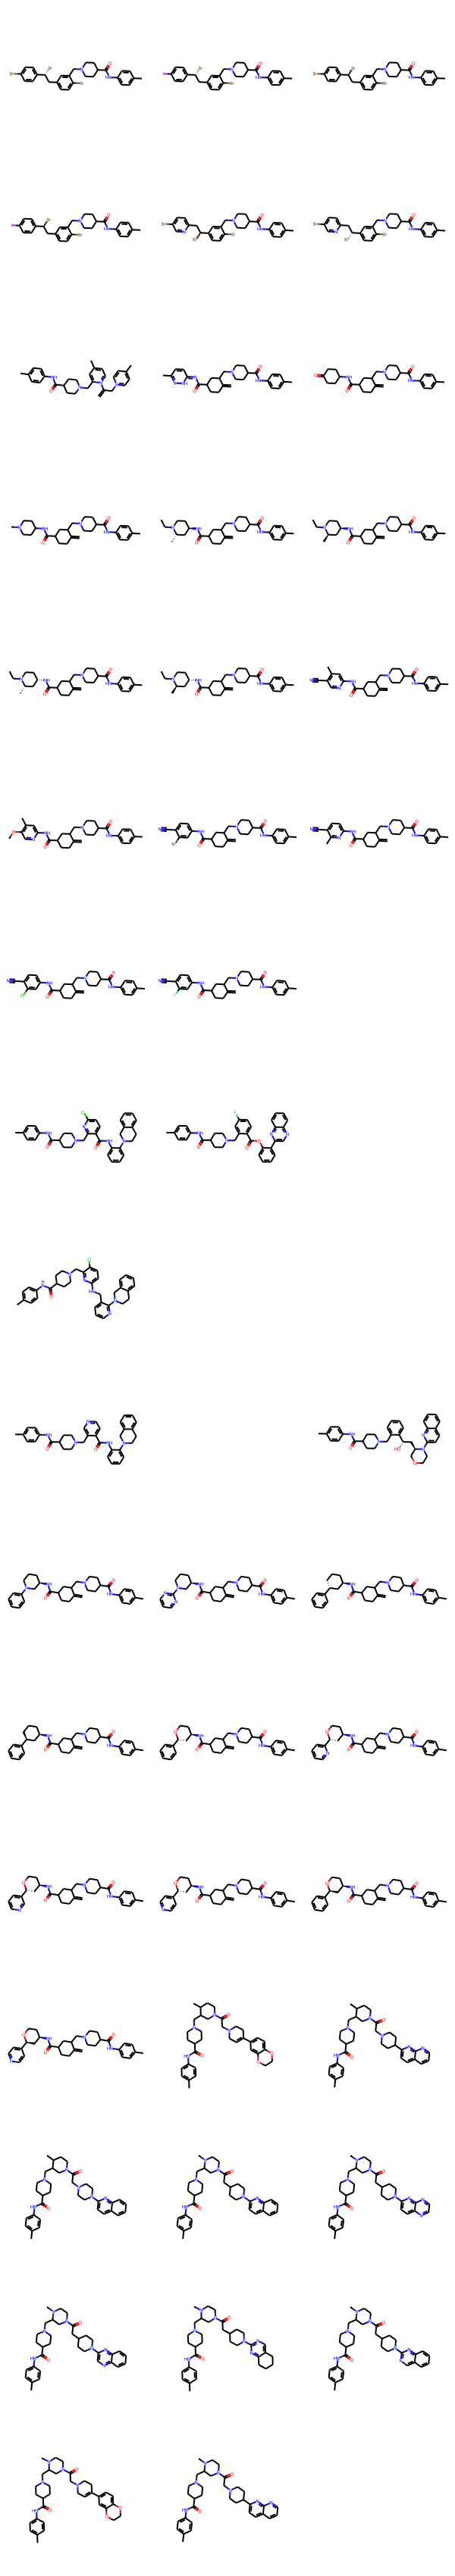

In [45]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in res+[smiles[0]]])